# Effects of Support

Before we jump into evaluation, we take a tangent to figure out the effects of supports on our prediction

As a quick reminder, a support is like a piece of evidence that reinforces a hypothesis. With multiple supports, this hypothesis becomes more reliable.

We used support in our similarity algorithm between **2 players**, ensuring that they have **enough** common maps before judging their similarity. We coin it **Pair Support**
We also used it to predict an accuracy of a map, across **multiple players**. Giving us an idea on how many players is **enough** to predict a score well. We coin it **Similarity Support**

Thus, we study the effects of these 2 supports.
- Pair Support
- Similarity Support.

## Hypothesis

I hypothesize that the number of pair supports will affect evaluation accuracy.

This is because, if the number of pair supports is low, then the similarity fitting metric will not be reliable. i.e. if the number of points fitted (support) is low, the curve fit may not yield a representable metric.

To prove this, we will need to see a graph of **Pair Supports**, **Evaluation Residual**.
If the residual changes w.r.t. the supports, then it's true.

In [6]:
import warnings
from pathlib import Path

if True:
    # PyCharm linting keeps wrecking this import, so it's in a True cond
    from opal.score.similarity.similarity import similarity_pair, similarity_predict, PredCorrectionTransformer
from opal.score.dataset import Dataset
from opal.score.preprocessing_dynamic import PreprocessingDynamic

warnings.filterwarnings('ignore')

data_path = Path("../../data/osu/scores/")

df = PreprocessingDynamic(
    Dataset(data_path, "top1k").joined_filtered_df,
    unpopular_maps_thres=0.4,
    unpopular_plays_thres=0.4,
    sr_min_thres=2.5,
    acc_filter=(0.85, 9),
    score_filter=None
).filter(calc_acc=True)
df, df_sim, df_support, qt = similarity_pair(df, min_support=2)
pred = similarity_predict(df, df_sim, qt)
pct = PredCorrectionTransformer()
pred['predict_pct'] = pct.fit_transform(pred['accuracy'], pred['predict'])

by_score_year 887452 -> 541019
by_sr 541019 -> 481548
by_unpopular_maps 481548 -> 146091
by_unpopular_plays 146091 -> 17824
by_acc_filter 17824 -> 17801
by_remove_mod 17801 -> 15897
Users Left: 139 | Beatmaps Left: 224


100%|██████████| 143/143 [00:05<00:00, 26.00it/s]


Let's take a glance at the pair support matrix & similarity interaction matrix
The values indicate the number of supports per user & similarity respectively.

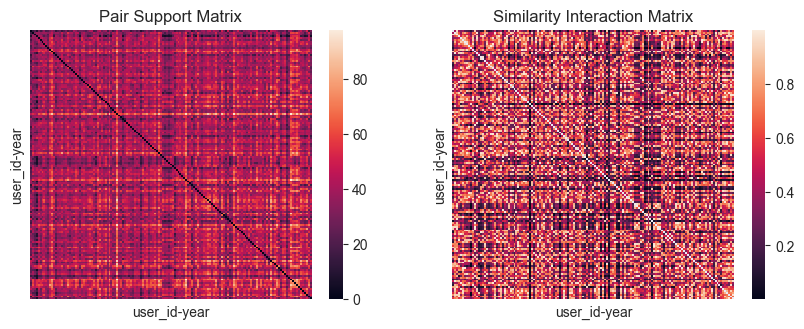

In [7]:
import seaborn as sns
from matplotlib import pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 3.5))
_ = sns.heatmap(df_support, yticklabels=False, xticklabels=False, ax=axs[0])
_ = axs[0].set_title("Pair Support Matrix")
_ = sns.heatmap(df_sim, yticklabels=False, xticklabels=False, ax=axs[1])
_ = axs[1].set_title("Similarity Interaction Matrix")

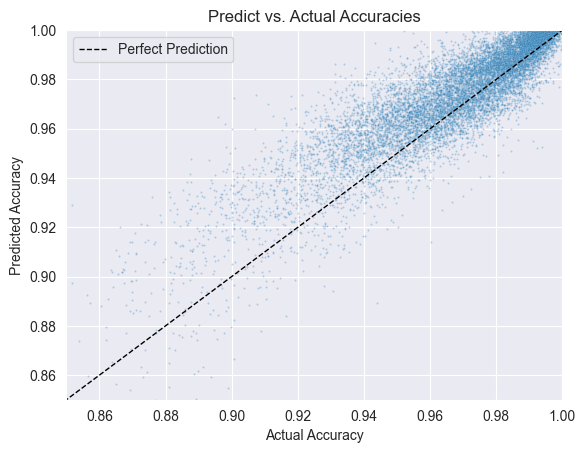

In [8]:
def plot_acc(actual, pred):
    sns.scatterplot(actual, pred, s=2,
                    alpha=0.3)
    _ = plt.plot([0, 1], [0, 1], color='black', linestyle='dashed',
                 linewidth=1, label='Perfect Prediction')
    _ = plt.xlim([0.85, 1])
    _ = plt.ylim([0.85, 1])
    _ = plt.xlabel("Actual Accuracy")
    _ = plt.ylabel("Predicted Accuracy")
    _ = plt.legend()
    _ = plt.title("Predict vs. Actual Accuracies")


plot_acc(pred['accuracy'], pred['predict_pct'])

In [9]:
from opal.score.similarity.similarity import evaluate

print(evaluate(pred['accuracy'], pred['predict']))
print(evaluate(pred['accuracy'], pred['predict_pct']))

Evaluation(mse=0.01587273888373097, r2=0.0970907758107068)
Evaluation(mse=0.012616750880982231, r2=0.6715037493284778)


We put a threshold to the number of supports by boolean masking `df_support`

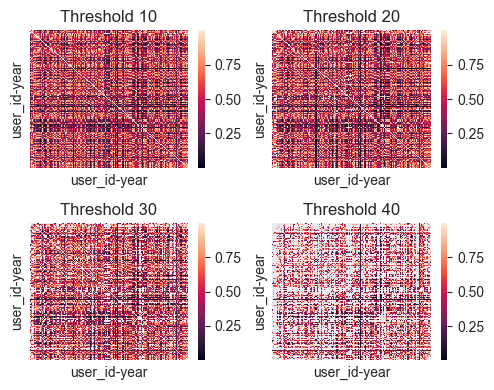

In [29]:
fig, axs = plt.subplots(2, 2, figsize=(5, 4))

for thres, ax in zip((10, 20, 30, 40), axs.flatten()):
    df_sim_thres = df_sim.copy(deep=True)
    sns.heatmap(df_sim_thres[df_support > thres], yticklabels=False, xticklabels=False, ax=ax)
    ax.set_title(f"Threshold {thres}")

fig.tight_layout()

We see that the number of similarities available for prediction changes with threshold.
We can thus run the prediction by varying the number of similarities available

In [30]:
evals = {}
for thres, ax in zip((10, 20, 30, 40), axs.flatten()):
    df_sim_thres = df_sim.copy(deep=True)
    df_sim_thres = df_sim_thres[df_support > thres]
    sns.heatmap(df_sim_thres, yticklabels=False, xticklabels=False, ax=ax)
    ax.set_title(f"Threshold {thres}")

    pred = similarity_predict(df, df_sim_thres, qt)
    pct = PredCorrectionTransformer()
    pred['predict_pct'] = pct.fit_transform(pred['accuracy'], pred['predict'])
    evals[thres] = evaluate(pred['accuracy'], pred['predict'])

100%|██████████| 143/143 [00:05<00:00, 27.98it/s]


In [31]:
evals

{10: Evaluation(mse=0.01587247309438148, r2=0.09716449709927977),
 20: Evaluation(mse=0.01586707252250265, r2=0.09882356543670967),
 30: Evaluation(mse=0.015842037293732042, r2=0.10770749035874938),
 40: Evaluation(mse=0.015735302595371408, r2=0.14848923448232387)}